In [2]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
    
# tf.config.experimental.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [4]:
%%capture
prefix = 'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/weather/jobs/transform_batch/20220925-014051_e32aa567fa482e970513332d1d24fd51'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24
features_length = 4

In [5]:
#combine validation set and test set to generate a bigger validation set
validate_test_X = pd.concat([validate_X, test_X])
validate_test_y = pd.concat([validate_y, test_y])

In [ ]:
#define a pre-processing function to add calendar feature: but not improve the result)
#def add_calendar(df):
    #df = df.reset_index(level=['time'])
    #df["year"] = df["time"].dt.year
    #df["month"] = df["time"].dt.month
    #df["day"] = df["time"].dt.day
    #df = df.drop(['time'],axis =1)
    #return df

In [6]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, ('Albuquerque/1108/0', Timestamp('2015-02-16 09:00:00')) to ('Vancouver/806/12', Timestamp('2014-07-03 04:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  826464 non-null  float64
 1   humidity     826464 non-null  float64
 2   pressure     826464 non-null  float64
 3   wind_speed   826464 non-null  float64
dtypes: float64(4)
memory usage: 31.9+ MB


In [7]:
score_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57576 entries, ('Albuquerque/2249/0', Timestamp('2017-07-15 13:00:00')) to ('Vancouver/2623/10', Timestamp('2017-07-07 20:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  57576 non-null  float64
 1   humidity     57576 non-null  float64
 2   pressure     57576 non-null  float64
 3   wind_speed   57576 non-null  float64
dtypes: float64(4)
memory usage: 2.1+ MB


In [8]:
train_X.head()

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00   276.323000      47.0    1031.0   
                   2015-02-16 10:00:00   275.097667      45.0    1032.0   
                   2015-02-16 11:00:00   273.931333      48.0    1032.0   
                   2015-02-16 12:00:00   274.380000      46.0    1033.0   
                   2015-02-16 13:00:00   272.675333      51.0    1033.0   

                                        wind_speed  
sample             time                             
Albuquerque/1108/0 2015-02-16 09:00:00         3.0  
                   2015-02-16 10:00:00         3.0  
                   2015-02-16 11:00:00         2.0  
                   2015-02-16 12:00:00         2.0  
                   2015-02-16 13:00:00         1.0

In [9]:
test_X.head()

temperature  humidity  pressure  \
sample             time                                                   
Albuquerque/2155/0 2017-04-14 08:00:00       285.65      36.0    1017.0   
                   2017-04-14 09:00:00       282.91      30.0    1016.0   
                   2017-04-14 10:00:00       283.66      42.0    1017.0   
                   2017-04-14 11:00:00       284.12      32.0    1016.0   
                   2017-04-14 12:00:00       282.01      51.0    1017.0   

                                        wind_speed  
sample             time                             
Albuquerque/2155/0 2017-04-14 08:00:00         4.0  
                   2017-04-14 09:00:00         1.0  
                   2017-04-14 10:00:00         4.0  
                   2017-04-14 11:00:00         4.0  
                   2017-04-14 12:00:00         2.0

In [10]:
train_X.groupby('sample').size()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
                      ..
Vancouver/806/5       24
Vancouver/806/6       24
Vancouver/806/7       24
Vancouver/806/8       24
Vancouver/806/9       24
Length: 34436, dtype: int64

In [11]:
train_X.loc['Vancouver/806/9']

,temperature,humidity,pressure,wind_speed
time,,,,
2014-07-02 02:00:00,301.41,42.0,1008.0,5.0
2014-07-02 03:00:00,297.92,69.0,1008.0,3.0
2014-07-02 04:00:00,298.45,83.0,1007.0,3.0
2014-07-02 05:00:00,295.22,77.0,1008.0,4.0
2014-07-02 06:00:00,295.54,77.0,1008.0,4.0
2014-07-02 07:00:00,295.73,82.0,1007.0,1.0
2014-07-02 08:00:00,295.34,64.0,1007.0,1.0
2014-07-02 09:00:00,292.60,88.0,1007.0,1.0
2014-07-02 10:00:00,293.74,88.0,1007.0,1.0


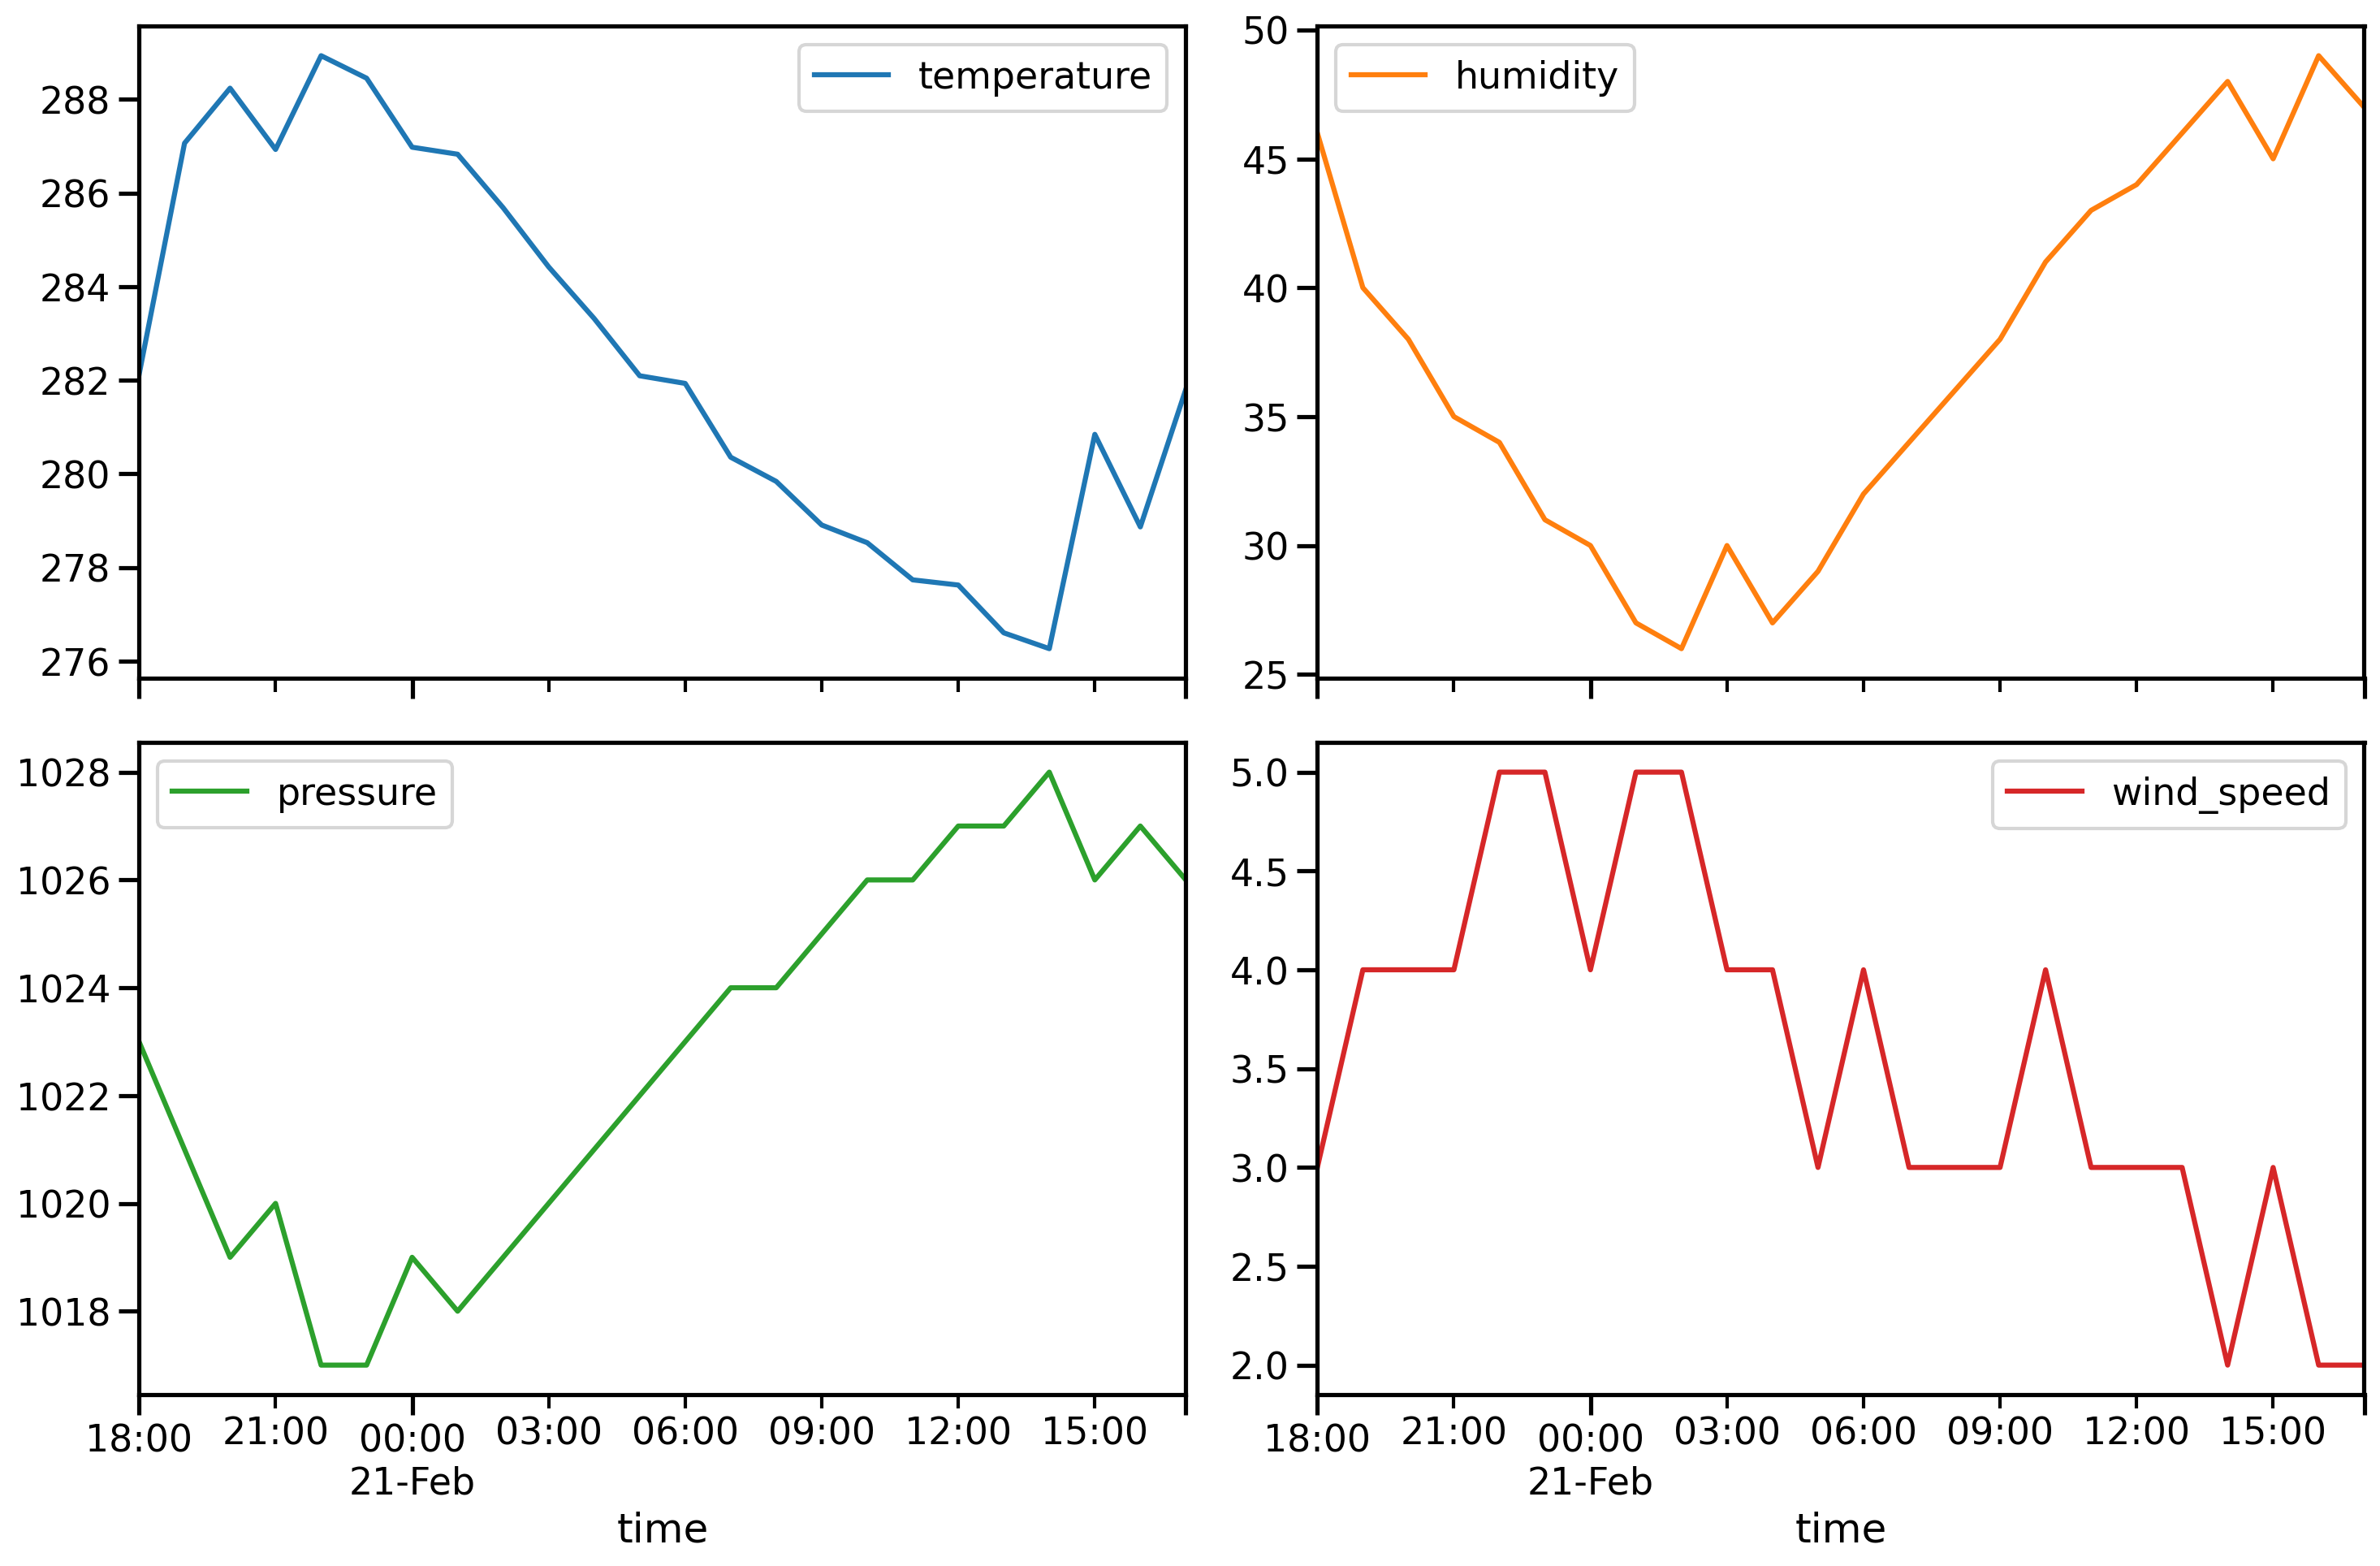

In [12]:
train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
plt.tight_layout()

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
    'validate_test': scaler.transform(validate_test_X)
}

In [14]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(826464, 4)","(34436, 24, 4)"
train_y,"(826464, 4)","(34436, 24)"


In [15]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)

# Task: Transform other segments of the dataset (test, and score).
# Enter your code here.
test_X_nd, test_y_nd = frame_to_ndarray(scaled_X['test'], test_y)
validate_test_X_nd, validate_test_y_nd = frame_to_ndarray(scaled_X['validate_test'], validate_test_y)
score_X_nd = scaled_X['score'].reshape(-1, condition_window, features_length).astype('float32')

In [16]:
# Let's confirm the expected shape.

pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
        test_X_nd.shape, 
        test_y_nd.shape,
        score_X_nd.shape,
        validate_test_X_nd.shape, 
        validate_test_y_nd.shape
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape),
        expected_X_shape(test_X.shape), 
        expected_y_shape(test_y.shape), 
        expected_X_shape(score_X.shape),
        expected_X_shape(validate_test_X.shape),
        expected_X_shape(validate_test_y.shape)
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y', 'test_X', 'test_y', 'score_X', 'validate_test_X', 'validate_test_y']
)

,actual shape,expected shape
train_X,"(34436, 24, 4)","(34436, 24, 4)"
train_y,"(34436, 24)","(34436, 24)"
validate_X,"(2288, 24, 4)","(2288, 24, 4)"
validate_y,"(2288, 24)","(2288, 24)"
test_X,"(2177, 24, 4)","(2177, 24, 4)"
test_y,"(2177, 24)","(2177, 24)"
score_X,"(2399, 24, 4)","(2399, 24, 4)"
validate_test_X,"(4465, 24, 4)","(4465, 24, 4)"
validate_test_y,"(4465, 24)","(4465, 24, 4)"


In [64]:
from tensorflow.keras.layers import GRU, Dense, BatchNormalization, LSTM, LeakyReLU, Dropout, Bidirectional,TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import regularizers

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

layers = [      
        LSTM(          #change GRU Layer to LSTM Layer                        
            input_shape=(condition_window, features_length),    
            units=24,  #change units to 24
            return_sequences=True,
            recurrent_activation='sigmoid',
            #reset_after=True,
            kernel_initializer=GlorotUniform(seed=42),
            recurrent_initializer=GlorotUniform(seed=43),
            activity_regularizer=regularizers.L2(0.0001),
        ),

        BatchNormalization(),  
    

       
        LSTM(         #change GRU Layer to LSTM Layer
            units=24, #change units to 24
            return_sequences=False,
            recurrent_activation='sigmoid',
            #reset_after=True,
            kernel_initializer=GlorotUniform(seed=46),
            recurrent_initializer=GlorotUniform(seed=47),
            #recurrent_dropout = 0.2,
            activity_regularizer=regularizers.L2(0.0001),   #add a L2 regularizer
        ), 
        
    
        BatchNormalization(), 


    
        #Dense(units=48,  kernel_initializer=GlorotUniform(seed=48),activation = 'relu'),
        
        #BatchNormalization(),

        Dense(
            units=prediction_window,
            kernel_initializer=GlorotUniform(seed=52),
            activation='linear'
        ),

]

model = Sequential(layers)

In [65]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 24, 24)            2784      
                                                                 
 batch_normalization_24 (Bat  (None, 24, 24)           96        
 chNormalization)                                                
                                                                 
 lstm_25 (LSTM)              (None, 24)                4704      
                                                                 
 batch_normalization_25 (Bat  (None, 24)               96        
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 24)                600       
                                                                 
Total params: 8,280
Trainable params: 8,184
Non-traina

In [66]:
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam, RMSprop,SGD

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.

model.compile(
    optimizer=SGD(lr=0.001),   #change learning_rate to 0.001
    loss='mean_squared_error',
    metrics=[
        'mean_absolute_error',
        r2_score,
        mean_error
    ]
)

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [67]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

# IMPORTANT: In order to pass the assignment, you need
# to improve the architecture and/or training procedure of this model.
# You CAN NOT submit the model as is. Please add plain English Python
# comments on how you modified the model and/or training procedure.


history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=20,   #change epochs to 20
    batch_size=48, #change batch_size to 48
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='val_loss',   #change monitor to val_loss
            min_delta=0.1,
            patience=5,
            cooldown=10,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',   #change monitor to val_loss
            min_delta=0.1,
            patience=10
        )
    ]
)

Epoch 1/20
718/718 [==============================] - 14s 16ms/step - loss: 3916.7979 - mean_absolute_error: 18.9280 - r2_score: -29.5211 - mean_error: -15.1714 - val_loss: 24.9018 - val_mean_absolute_error: 3.8861 - val_r2_score: -0.0452 - val_mean_error: 0.9479 - lr: 0.0010
Epoch 2/20
718/718 [==============================] - 10s 15ms/step - loss: 22.7838 - mean_absolute_error: 3.7526 - r2_score: 0.8268 - mean_error: -0.0071 - val_loss: 22.1265 - val_mean_absolute_error: 3.5839 - val_r2_score: 0.1081 - val_mean_error: 0.3781 - lr: 0.0010
Epoch 3/20
718/718 [==============================] - 10s 15ms/step - loss: 19.6641 - mean_absolute_error: 3.4536 - r2_score: 0.8500 - mean_error: 0.0042 - val_loss: 20.9306 - val_mean_absolute_error: 3.5259 - val_r2_score: 0.1029 - val_mean_error: 0.6559 - lr: 0.0010
Epoch 4/20
718/718 [==============================] - 11s 15ms/step - loss: 17.0721 - mean_absolute_error: 3.1828 - r2_score: 0.8698 - mean_error: 0.0024 - val_loss: 22.1795 - val_mean

In [68]:
# Note that Keras evaluates metrics in batches,
# which is okay for averaging-stable metrics like ME, MSE, and MAE,
# but R2 requires full dataset to evaluate precisely.

# This implies two things:
# 1) R2 as reported during training is not precise
# 2) when evaluating R2 after training, batch size must match dataset size

nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd),
    'test': (test_X_nd, test_y_nd),
    'validate_test': (validate_test_X_nd, validate_test_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'R2', 'ME'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(3)

rnn_metrics

train                      validate                         test         \
       MSE    MAE     R2     ME      MSE    MAE     R2     ME     MSE    MAE   
rnn  9.898  2.304  0.928  0.037   17.307  3.073  0.804  0.241  12.633  2.651   

                  validate_test                       
        R2     ME           MSE    MAE     R2     ME  
rnn  0.828 -0.224        15.028  2.867  0.889  0.015

In [69]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate','test']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

In [70]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, (slice(None), ['MSE', 'R2'])].round(2)

,train,validate,test,validate_test,train,validate,test,validate_test
,MSE,MSE,MSE,MSE,R2,R2,R2,R2
mean,26.77,37.23,28.52,NaN,0.80,0.58,0.61,NaN
constant,21.82,40.25,20.20,NaN,0.84,0.54,0.72,NaN
regression,30.53,29.94,33.64,NaN,0.78,0.66,0.54,NaN
rnn,9.90,17.31,12.63,15.03,0.93,0.80,0.83,0.89


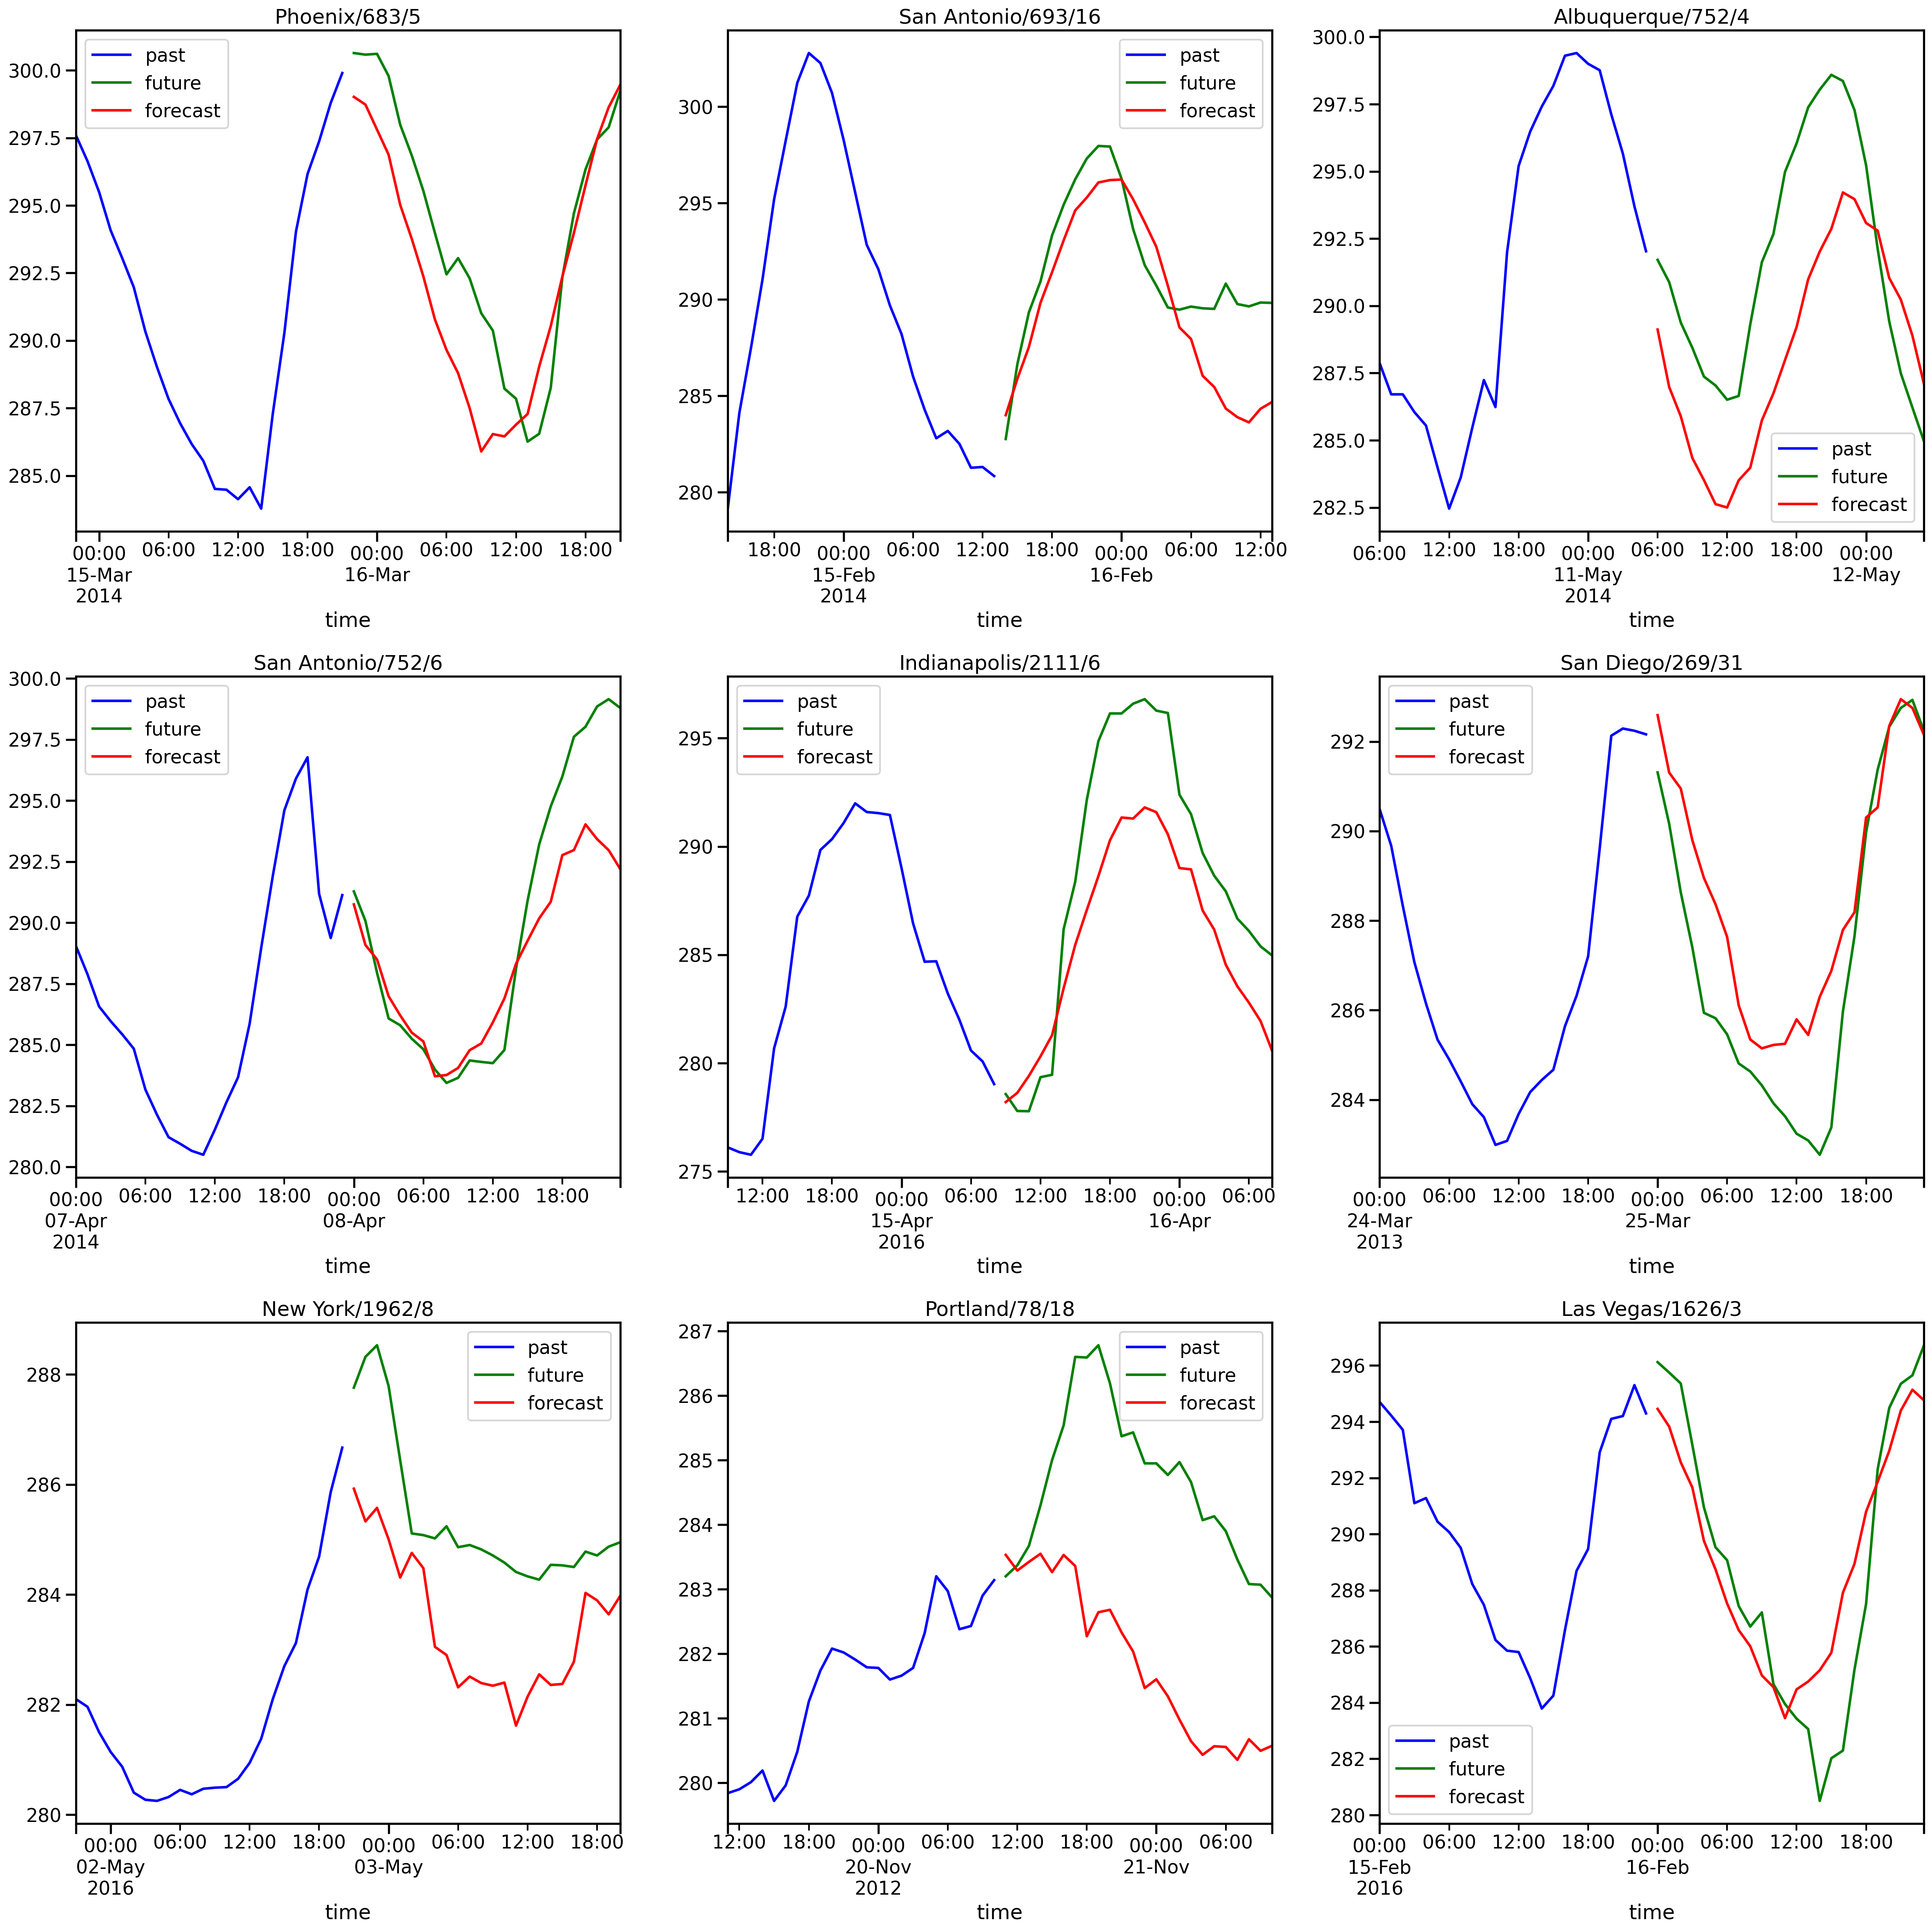

In [71]:
from utils import nd_target_like_panel, plot_random_forecasts

train_y_hat = nd_target_like_panel(train_y, model.predict(train_X_nd))

plot_random_forecasts(
    train_X['temperature'],
    train_y['temperature'],
    train_y_hat.rename(columns={'temperature': 'forecast'})
)

In [72]:
# TODO: save your predictions on the Score segment as a Pandas data frame
# into a variable named score_y_hat.
score_y_hat = pd.DataFrame(model.predict(score_X_nd).reshape((57576,1)), columns = ['temperature'])

# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
# Use NumPy's reshape() or ravel() functions to achieve this.

# Finally, the data frame needs to have string column names in order to be saved
# as a Parquet file. If you convert a NumPy array to Pandas data frame,
# column names will be integers, but you can replace the columns names.
# There was a similar example of this in the notebook from the first assignment.

# Expected output: (Index(['temperature'], dtype='object'), (57576, 1))
score_y_hat.columns, score_y_hat.shape

(Index(['temperature'], dtype='object'), (57576, 1))

In [73]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

In [77]:
score_y_hat

,temperature
0,293.116943
1,294.972687
2,296.181000
3,297.803619
4,298.795898
...,...
57571,288.709930
57572,289.516235
57573,290.287720
57574,291.205170
